# Cleaning Dataset 
_____

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns

import missingno as msno

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

import plotly.graph_objects as go
import plotly.figure_factory as ft 

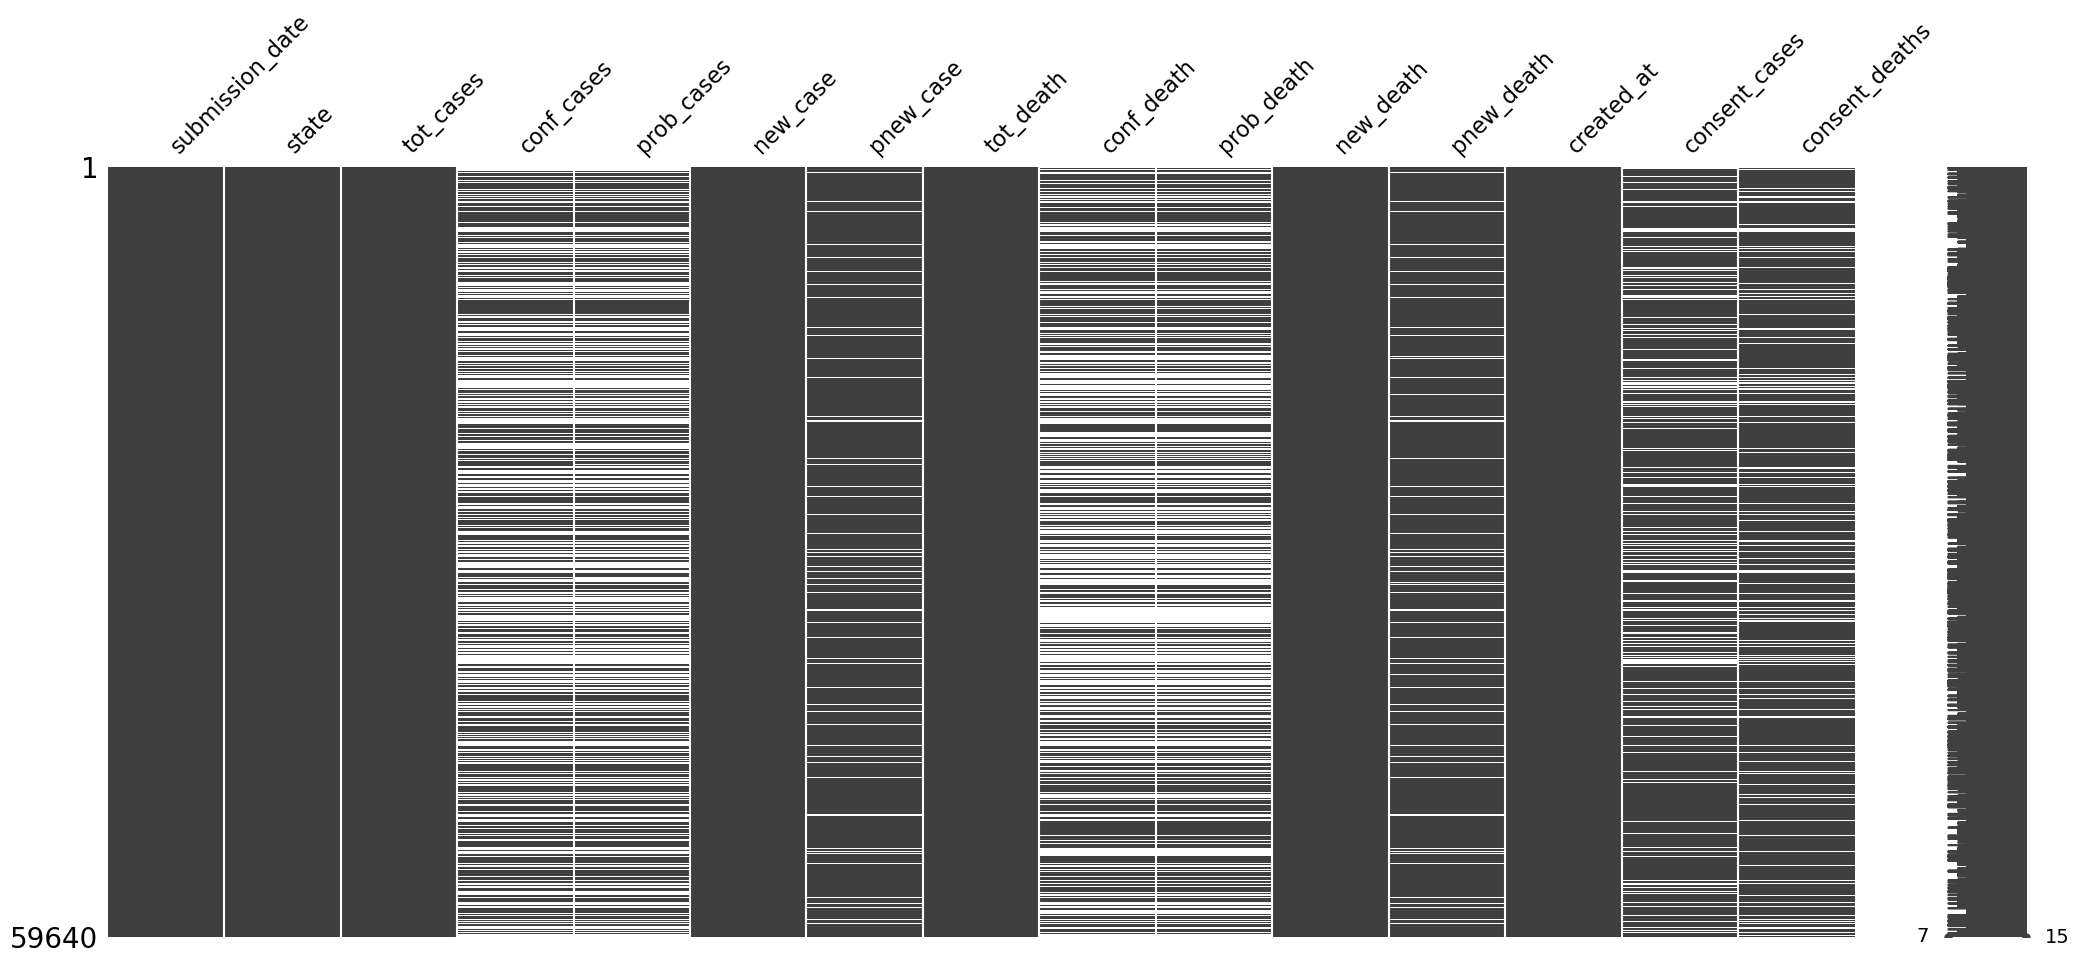

In [76]:
covid = pd.read_csv('../data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
covid['submission_date'] = pd.to_datetime(covid['submission_date'])
msno.matrix(covid);

In [77]:
covid = covid[['submission_date','state','tot_cases','new_case','tot_death','new_death']]
covid.set_index('submission_date', inplace=True)
covid.sort_index(inplace=True)
covid

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2022-10-11,HI,"348,570",0,"1,682",0
2022-10-11,MP,"13,171",0,40,0
2022-10-11,UT,"1,040,147",0,"5,028",0


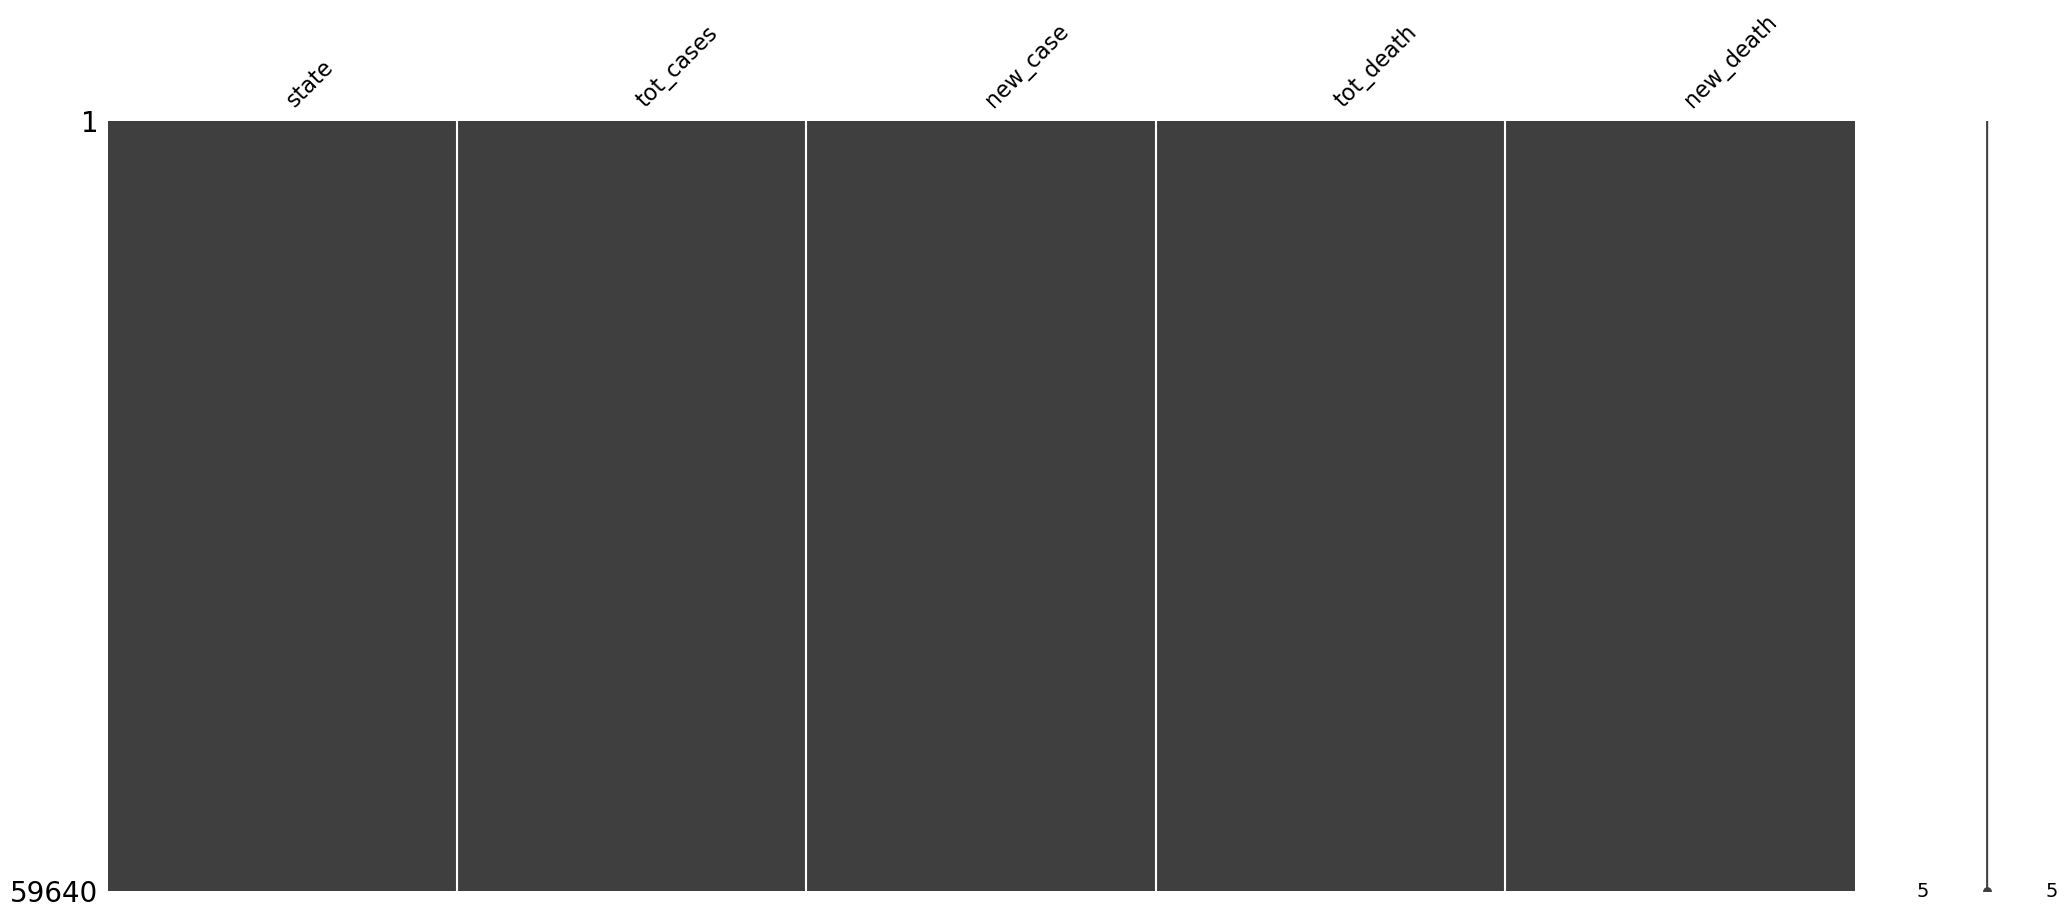

In [78]:
msno.matrix(covid);

In [79]:
col =['tot_cases', 'new_case', 'tot_death', 'new_death']
for c in col:
    covid[c] = covid[c].map( lambda x: x.replace(',','')).astype(int)
covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [80]:
covid.shape

(59640, 5)

In [81]:
df_cases = covid.copy()

In [82]:
covid.to_csv('../data/clean_data/covid_cases_us_clean.csv')

#  EDA Dataset
_____

I will perform EDA in US cases so I need to sum cases from all states. \
To do this I will sum the cases for the same dates using group by dates. \
I can't use tot_cases because this column is acumulative so I will sum the new cases.

In [83]:
# Creating a copy of dataset to perform EDA
df = covid.copy()
df

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2022-10-11,HI,348570,0,1682,0
2022-10-11,MP,13171,0,40,0
2022-10-11,UT,1040147,0,5028,0


In [84]:
df = df.groupby(by=df.index).sum()
df.head()

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0


In [85]:
df.head()

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0


# Times Series EDA
---

We trying to build a Time Series on covid cases since the begining of the pandemic so first we need to check for some assumptions like stationarity, trends and seasonalities on the dataset.

In [86]:
# dropping columns
df.drop(columns=['tot_cases','tot_death','new_death'], inplace=True)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994 entries, 2020-01-22 to 2022-10-11
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   new_case  994 non-null    int64
dtypes: int64(1)
memory usage: 15.5 KB


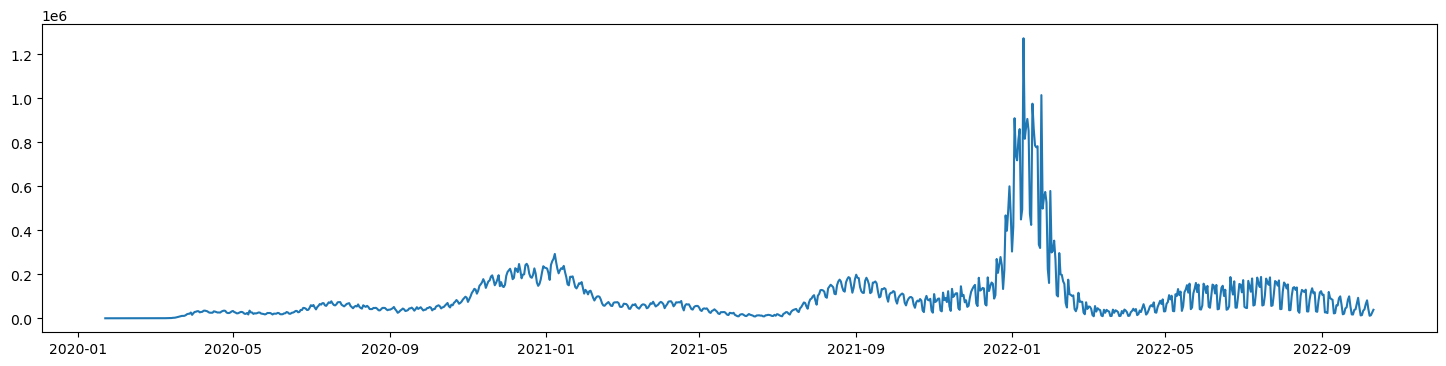

In [88]:
plt.figure(figsize=(18,4))
plt.plot(df['new_case']);

In [89]:
# Resample data to smothing out
df = df.resample('W').mean()
df_cases_diff = df.copy()
df.head()

,new_case
submission_date,
2020-01-26,1.600000
2020-02-02,0.714286
2020-02-09,1.000000
2020-02-16,0.571429
2020-02-23,3.428571


In [90]:
df['moving_average_1'] = df['new_case'].rolling(window=1).mean()
df['moving_average_4'] = df['new_case'].rolling(window=4).mean()
df['moving_average_13'] = df['new_case'].rolling(window=13).mean()
df.dropna(inplace=True)
df.head()

,new_case,moving_average_1,moving_average_4,moving_average_13
submission_date,,,,
2020-04-19,27436.857143,27436.857143,25772.964286,8494.298901
2020-04-26,30087.571429,30087.571429,28939.857143,10808.604396
2020-05-03,27584.571429,27584.571429,29096.714286,12930.439560
2020-05-10,24957.142857,24957.142857,27516.535714,14850.142857
2020-05-17,24088.142857,24088.142857,26679.357143,16703.032967


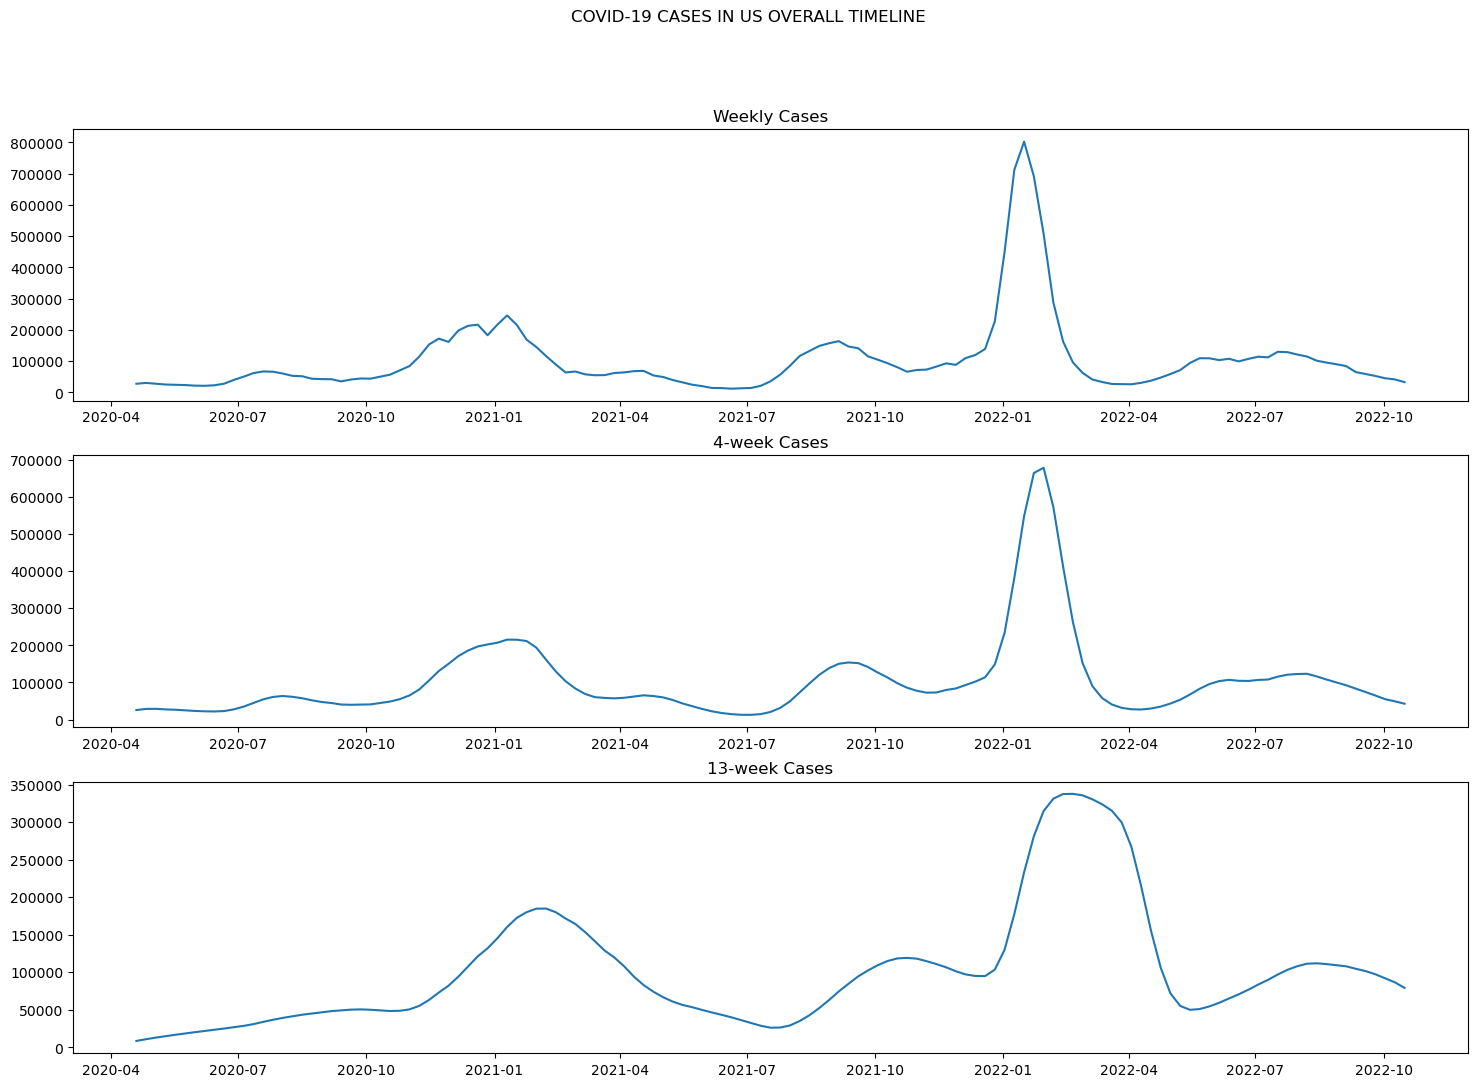

In [91]:
fig, axes = plt.subplots(nrows=3, figsize=(18,12))

axes[0].plot(df['moving_average_1'])
axes[1].plot(df['moving_average_4'])
axes[2].plot(df['moving_average_13'])

fig.suptitle('COVID-19 CASES IN US OVERALL TIMELINE');
axes[0].title.set_text('Weekly Cases')
axes[1].title.set_text('4-week Cases')
axes[2].title.set_text('13-week Cases')


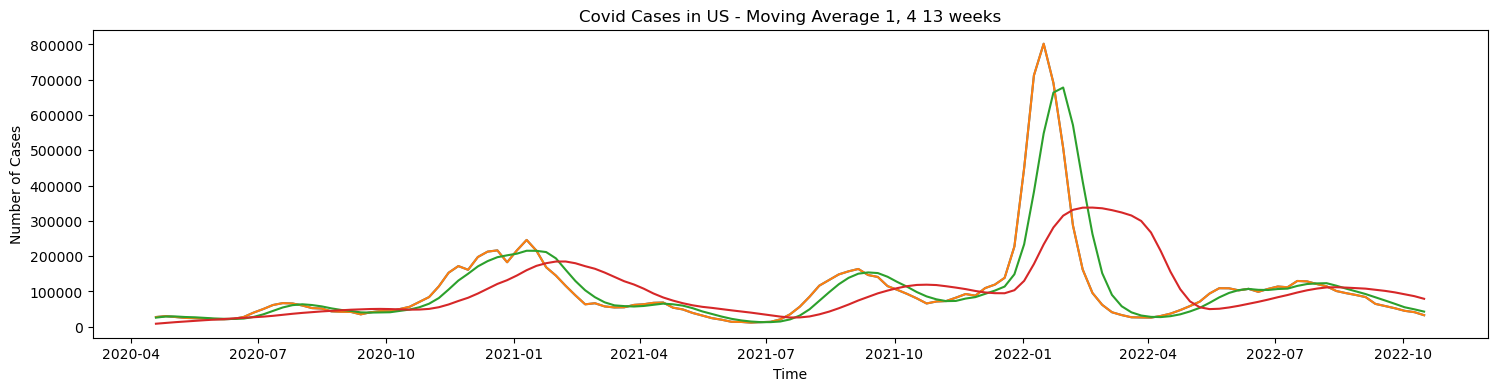

In [92]:
plt.figure(figsize=(18,4))
plt.plot(df)
plt.title('Covid Cases in US - Moving Average 1, 4 13 weeks')
plt.xlabel('Time')
plt.ylabel('Number of Cases');

## Evaluating Stationary
---

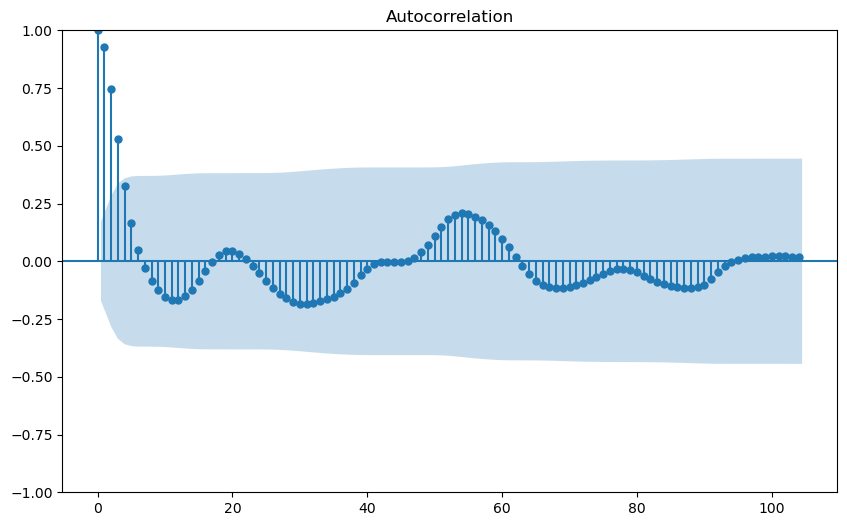

In [93]:
# Generate the ACF plot on Weekly Sales data up to 52 time periods.
plt.rc("figure", figsize=(10,6))
plot_acf(df['new_case'], lags = 104);

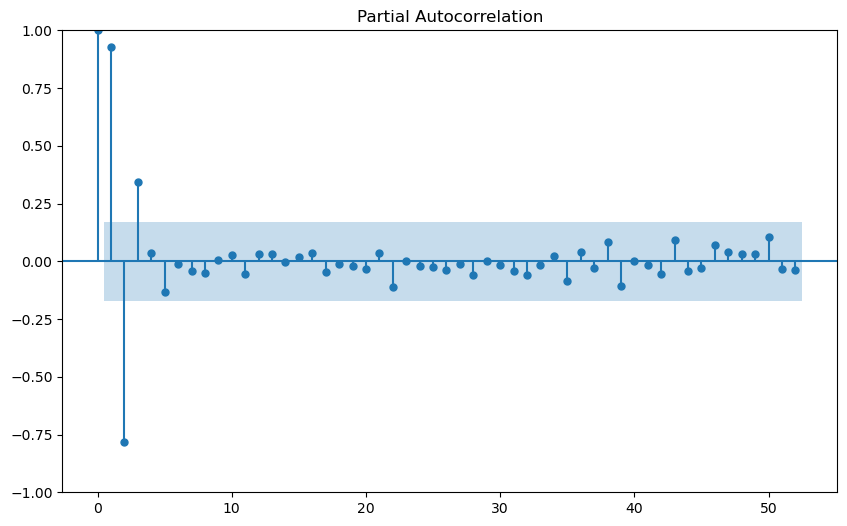

In [94]:
plt.rc("figure", figsize=(10,6))
plot_pacf(df['new_case'], lags = 52, method='ywm' );

Applying Dickey-Test to check our hypotesis:

In [95]:
# Run ADF test on original (non-differenced!) data.
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df['new_case']))

Test Statistic   -3.264758
p-value           0.016529
dtype: float64

Because our p (0.016529) is bigger than alpha (0.01) we can not  accept that our series "new_cases" is stationary. Let's apply diff() on data. 

In [96]:
# Run ADF test on differenced once data.
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Run ADF test on differenced once data.
interpret_dftest(adfuller(df['new_case'].diff().dropna()))

Test Statistic   -8.312911e+00
p-value           3.746933e-13
dtype: float64

After apply diff() our p (3.746933e-13) is smaller than alpha (0.01) and now we can accept that our series "new_cases" is stationary. The value of d will be '1' and we going to gridsearch p and q values.

# Cases by State
____

In [97]:
df_cases

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2022-10-11,HI,348570,0,1682,0
2022-10-11,MP,13171,0,40,0
2022-10-11,UT,1040147,0,5028,0


In [98]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [99]:
df_ = df_cases.loc['2022-06':'2022-10'].groupby(by='state').sum()
df5_state_cases = df_.sort_values(by='tot_cases', ascending=False).head(5)
states5_list = df5_state_cases.index
states5_list

Index(['CA', 'TX', 'FL', 'IL', 'PA'], dtype='object', name='state')

In [100]:
df_cases_states = df_cases.groupby(by='state').sum()
df_cases_states.sort_values(by='new_case', ascending=False)

,tot_cases,new_case,tot_death,new_death
state,,,,
CA,4364733842,11107087,50457009,95414
TX,3307212352,7691340,47538683,89344
FL,2877176184,7135916,40188788,81807
IL,1535904620,3778171,22194980,39791
NY,1301856010,3259603,17308667,29549
PA,1328107988,3249979,24628308,47169
NC,1233122110,3221966,13187799,26889
OH,1276191903,3149589,19056947,36187
GA,1256065315,2898910,20057017,39908


In [101]:
df_fips = pd.read_csv('../data/states_fips.csv')
df_fips.head(50)

,name,postal_code,fips
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6
5,Colorado,CO,8
6,Connecticut,CT,9
7,Delaware,DE,10
8,District of Columbia,DC,11
9,Florida,FL,12


In [102]:
list_state = list(df_cases.groupby(by='state').sum().index)
list_fips = list(df_fips['postal_code'])

In [103]:
set(list_state) - set(list_fips)

{'FSM', 'NYC', 'PW', 'RMI'}

In [104]:
# These are not US state
# FSM: Federated States of Micronesia
# PW: Palau
# RMI: Republic of Marshall Islands
not_state_list = ['FSM', 'PW', 'RMI', 'AS', 'GU', 'MP', 'PR', 'VI']

#### Let's checking for 5th states with higher covid cases/increasing trends recently (2022-07 until 2022-09).


In [105]:
df_recent = df_cases.loc['2022-07':'2022-09']

In [106]:
df_recent_states = df_recent.groupby(by='state').sum()
df_5state_recent_cases = df_recent_states.sort_values(by='new_case', ascending=False).head(5)
df5_state_cases


,tot_cases,new_case,tot_death,new_death
state,,,,
CA,1415290154,1681834,12377966,4695
TX,991447676,1031121,11700763,2527
FL,902598100,965939,10471082,6827
IL,475483264,475755,5187490,1656
PA,413327162,341282,6159392,2139


In [107]:
# Creating a list with 5 states with higher number of cases recently
states5_list = df_5state_recent_cases.index
states5_list

Index(['CA', 'TX', 'FL', 'IL', 'NC'], dtype='object', name='state')

In [108]:
df_recent[df_recent['state']==('CA'or'TX'or 'FL'or'NC'or'IL')]

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2022-07-01,CA,10143414,67396,91701,185
2022-07-02,CA,10143414,0,91701,0
2022-07-03,CA,10143414,0,91701,0
2022-07-04,CA,10143414,0,91701,0
2022-07-05,CA,10212491,69077,91795,94
...,...,...,...,...,...
2022-09-26,CA,11220161,0,95009,0
2022-09-27,CA,11220161,0,95009,0
2022-09-28,CA,11220161,0,95009,0


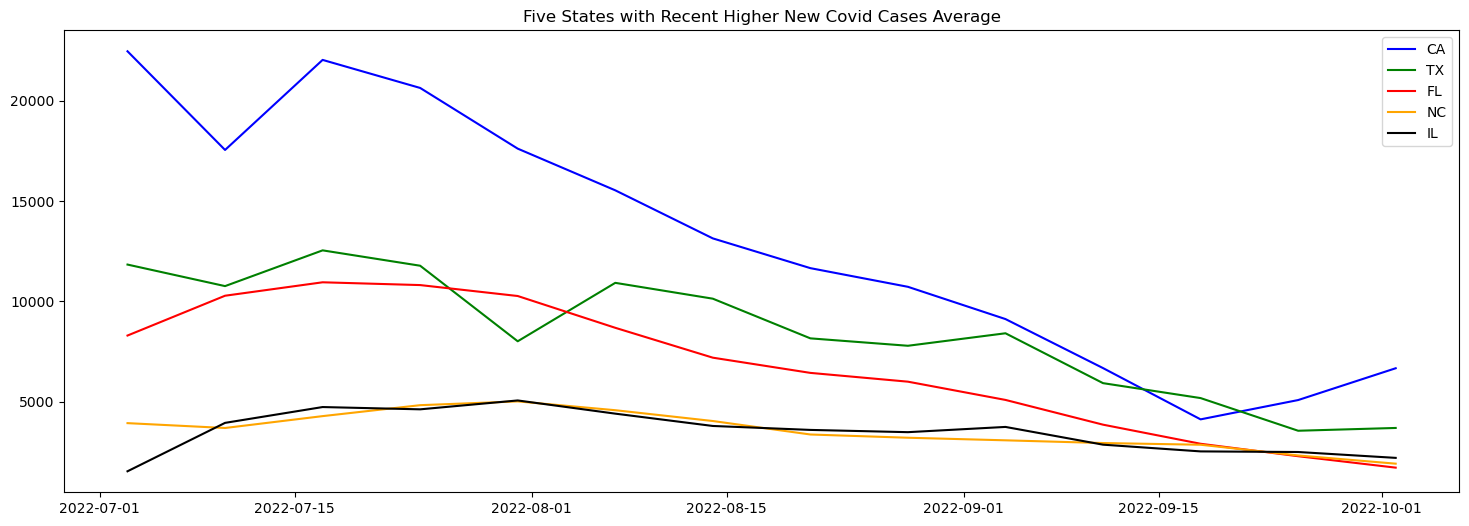

In [109]:
#['CA', 'TX', 'FL', 'IL', 'NC']
plt.figure(figsize=(18,6))
plt.plot(df_recent[df_recent['state']=='CA']['new_case'].resample('W').mean(), color='blue', label='CA')
plt.plot(df_recent[df_recent['state']=='TX']['new_case'].resample('W').mean(), color='green', label='TX')
plt.plot(df_recent[df_recent['state']=='FL']['new_case'].resample('W').mean(), color='red', label='FL')
plt.plot(df_recent[df_recent['state']=='NC']['new_case'].resample('W').mean(), color='orange', label='NC')
plt.plot(df_recent[df_recent['state']=='IL']['new_case'].resample('W').mean(), color='black', label='IL')


plt.title('Five States with Recent Higher New Covid Cases Average')
plt.xlabel('')
plt.ylabel('')
plt.legend();


In [110]:
df_cases_states = df_cases.groupby(by='state').sum()
df_cases_states.shape

(60, 4)

In [111]:
# Deleting theses 'states' ['FSM', 'PW', 'RMI', 'AS', 'GU', 'MP', 'PR', 'VI']
# Keeping DC and NYC. Total of 52 'US states'
df_cases_states.drop(index = not_state_list, inplace=True)
df_cases_states.shape

(52, 4)

In [112]:
df_cases_states.sort_index()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414
CO,658900625,1660829,6600246,13348
CT,367082955,888009,7159317,11385
DC,64506024,168122,929885,1383
DE,123511033,310527,1674285,3094


In [113]:
##!pip install plotly-geo==1.0.0
#!pip install geopandas==0.3.0
#!pip install pyshp==1.2.10
#!pip install shapely==1.6.3

In [114]:

#import pandas as pd
#import geopandas as gpd

In [115]:
df_cases_states.head()

,tot_cases,new_case,tot_death,new_death
state,,,,
AK,103800015,282632,533125,1186
AL,638327202,1528319,10915844,20498
AR,403775153,954552,5830937,12041
AZ,978893192,2275235,15992140,31644
CA,4364733842,11107087,50457009,95414


In [116]:
total_covid_cases = df_cases_states['new_case'].sum()
total_covid_cases

94811167

In [117]:
df_cases_states['pct_cases'] = df_cases_states['new_case']/total_covid_cases*100
df_cases_states.head(50).sort_values(by='pct_cases', ascending=False)

,tot_cases,new_case,tot_death,new_death,pct_cases
state,,,,,
CA,4364733842,11107087,50457009,95414,11.714957
TX,3307212352,7691340,47538683,89344,8.112272
FL,2877176184,7135916,40188788,81807,7.526451
IL,1535904620,3778171,22194980,39791,3.984943
NY,1301856010,3259603,17308667,29549,3.437995
PA,1328107988,3249979,24628308,47169,3.427844
NC,1233122110,3221966,13187799,26889,3.398298
OH,1276191903,3149589,19056947,36187,3.321960
GA,1256065315,2898910,20057017,39908,3.057562


In [118]:
import plotly.graph_objects as go

import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(
    data = go.Choropleth(
    locations = df_cases_states.index, # Spatial coordinates
    z = df_cases_states['pct_cases'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = ' US Covid Cases by State ',
    geo_scope='usa', # limite map scope to USA
)

fig.show()


In [119]:
import plotly.graph_objects as go

import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

fig = go.Figure(
    data = go.Choropleth(
    locations = df_cases_states.index, # Spatial coordinates
    z = df_cases_states['pct_cases'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = ' US Covid Cases by State ',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

# Covid Data
____

In [120]:
df_deaths = df_cases.copy()
df_deaths.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 4.7+ MB


In [121]:
df_deaths = df_deaths.groupby(by=df_deaths.index).sum()
df_deaths.head()

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0


In [122]:
df_deaths.drop(columns=['tot_cases','tot_death','new_case'], inplace=True)


In [123]:
df_deaths.sort_values(by='new_death', ascending=True)

,new_death
submission_date,
2020-01-22,0
2020-02-12,0
2020-02-13,0
2020-02-14,0
2020-02-15,0
...,...
2021-01-28,3880
2021-01-27,3955
2021-01-07,4000


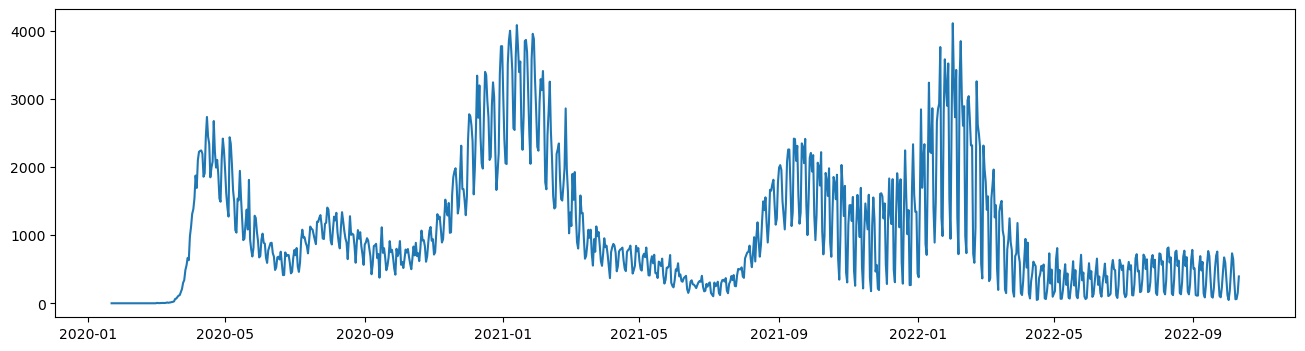

In [124]:
plt.figure(figsize=(16,4))
plt.plot(df_deaths['new_death']);

# Vacination Data
____


In [125]:
df_vacc = pd.read_csv('../data/clean_data/covid_vaccination_trends_clean.csv', low_memory=False)
df_vacc['Date'] = pd.to_datetime(df_vacc['Date'])
df_vacc.set_index('Date', inplace=True)
df_vacc.sort_index(inplace=True)
df_vacc.head(3)

,Location,Administered_Daily,Administered_Cumulative,Administered_7_Day_Rolling_Average,Admin_Dose_1_Daily,Admin_Dose_1_Cumulative,Admin_Dose_1_Day_Rolling_Average,Administered_Dose1_Pop_Pct,Administered_daily_change_report,Administered_daily_change_report_7dayroll,...,Series_Complete_Day_Rolling_Average,Series_Complete_Pop_Pct,Booster_Daily,Booster_Cumulative,Booster_7_Day_Rolling_Average,Additional_Doses_Vax_Pct,Second_Booster_50Plus_Daily,Second_Booster_50Plus_Cumulative,Second_Booster_50Plus_7_Day_Rolling_Average,Second_Booster_50Plus_Vax_Pct
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-13,GU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-13,FM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-13,MA,2.0,2.0,2.0,22.0,22.0,22.0,0.0,2.0,2.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Travel Data 
----

In [126]:
df_travel = pd.read_csv('../data/clean_data/travel_data_clean.csv')
df_travel['Date'] = pd.to_datetime(df_travel['Date'])
df_travel.set_index('Date', inplace=True)
df_travel.sort_index(inplace=True)
df_travel.head(3)

,Unnamed: 0,Level,State FIPS,State Postal Code,County FIPS,County Name,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,...,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Row ID,Week,Month
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,48496,County,19.0,IA,19099.0,Jasper County,9808.0,27377.0,105067.0,25699.0,...,12076.0,14098.0,12562.0,3154.0,875.0,366.0,121.0,19-19099-20190101,0,1
2019-01-01,48244,County,22.0,LA,22041.0,Franklin Parish,3370.0,16645.0,58353.0,13234.0,...,10190.0,8404.0,3921.0,1457.0,499.0,96.0,93.0,22-22041-20190101,0,1
2019-01-01,48245,County,22.0,LA,22043.0,Grant Parish,3812.0,18577.0,63157.0,12498.0,...,9178.0,10369.0,4178.0,1487.0,1434.0,303.0,85.0,22-22043-20190101,0,1


## North Carolina Analysis (Vacination/Cases/Travel)

In [127]:
df_nc_vcc = df_vacc[df_vacc["Location"]=='NC']
df_nc_vcc.drop(columns=['Location', 'Administered_Daily', 'Administered_Cumulative','Administered_7_Day_Rolling_Average',
       'Admin_Dose_1_Cumulative', 'Admin_Dose_1_Day_Rolling_Average','Administered_Dose1_Pop_Pct', 'Administered_daily_change_report',
       'Administered_daily_change_report_7dayroll', 'Series_Complete_Daily','Series_Complete_Cumulative', 'Series_Complete_Day_Rolling_Average',
       'Series_Complete_Pop_Pct', 'Booster_Cumulative','Booster_7_Day_Rolling_Average', 'Additional_Doses_Vax_Pct',
       'Second_Booster_50Plus_Daily','Second_Booster_50Plus_Cumulative','Second_Booster_50Plus_7_Day_Rolling_Average','Second_Booster_50Plus_Vax_Pct'], inplace=True)
df_nc_vcc = df_nc_vcc.groupby(by=df_nc_vcc.index).sum()
df_nc_vcc.head(3)

,Admin_Dose_1_Daily,Booster_Daily
Date,,
2020-12-13,121.0,0.0
2020-12-14,35.0,0.0
2020-12-15,885.0,0.0


In [128]:
df_nc_cases = df_cases[df_cases['state']=='NC']
df_nc_cases.drop(columns=['tot_cases','tot_death'], inplace=True)
df_nc_cases = df_nc_cases.groupby(by=df_nc_cases.index).sum()
df_nc_cases.head(3)

,new_case,new_death
submission_date,,
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0


In [129]:
df_nc_travel = df_travel[df_travel['State Postal Code']=='NC']
df_nc_travel.drop(columns=['Unnamed: 0', 'Level', 'State FIPS',
       'County FIPS', 'County Name',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips >=500', 'Row ID', 'Week', 'Month'], inplace=True)
df_nc_travel = df_nc_travel.groupby(by=df_nc_travel.index).sum()
df_nc_travel.head(3)

,Population Staying at Home,Population Not Staying at Home,Number of Trips
Date,,,
2019-01-01,2293224.0,8194860.0,26744044.0
2019-01-02,1784039.0,8704045.0,34513887.0
2019-01-03,1835778.0,8652306.0,35172928.0


In [130]:
df_nc_vcc_cases = pd.merge(df_nc_vcc, df_nc_cases, left_index=True, right_index=True)
df_nc_vcc_cases_travel = pd.merge(df_nc_vcc_cases, df_nc_travel,left_index=True, right_index=True)
df_nc_vcc_cases_travel.head(3)

,Admin_Dose_1_Daily,Booster_Daily,new_case,new_death,Population Staying at Home,Population Not Staying at Home,Number of Trips
2020-12-13,121.0,0.0,5416,80,2824126.0,7663958.0,26997271.0
2020-12-14,35.0,0.0,4158,57,2633024.0,7855060.0,29452421.0
2020-12-15,885.0,0.0,5418,81,2531246.0,7956838.0,31061593.0


In [131]:
#df_nc_vcc_cases_travel.to_csv('../data/data_VAR_Model.csv')

In [132]:
df_plot = df_nc_vcc_cases_travel.resample('W').mean()

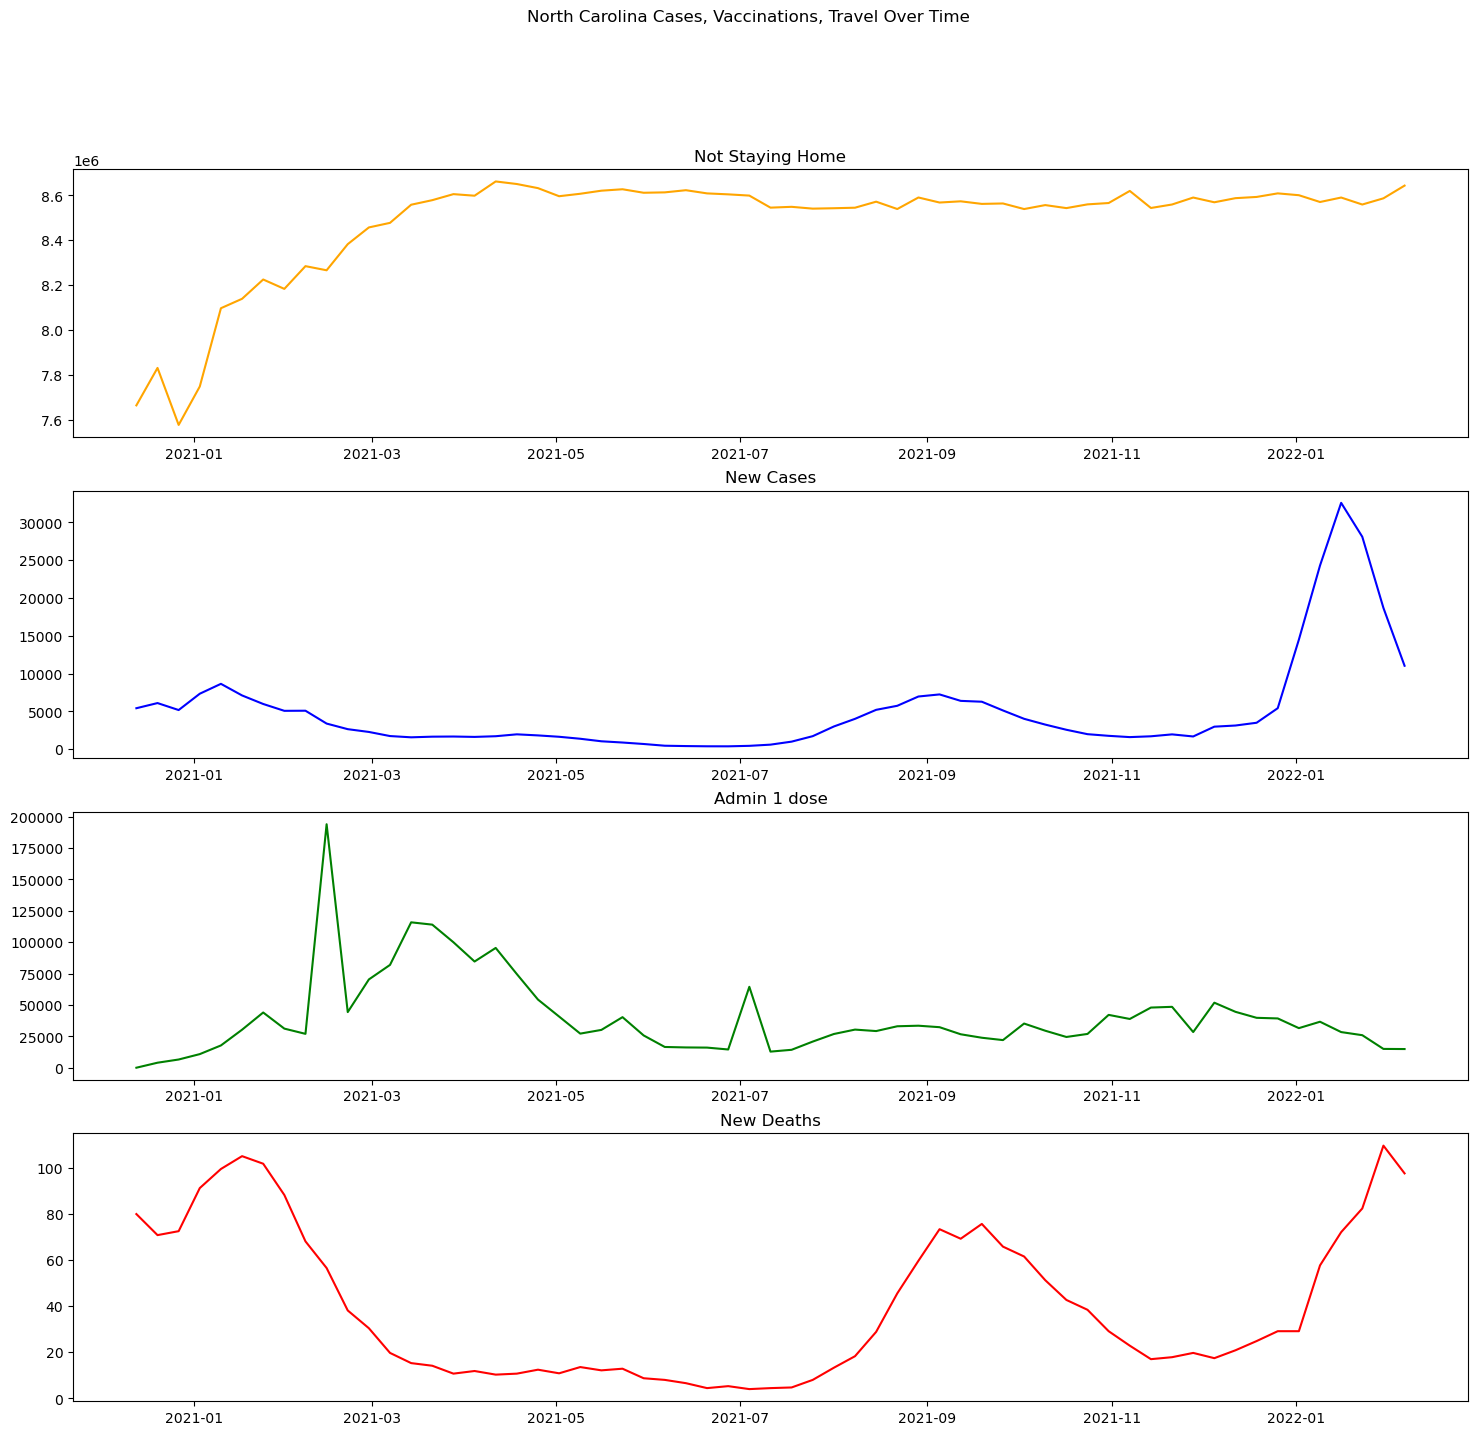

In [133]:
fig, axes = plt.subplots(nrows=4, figsize=(18,16))
axes[0].plot(df_plot['Population Not Staying at Home'], color = 'orange');
axes[1].plot(df_plot['new_case'],color = 'blue');
axes[2].plot(df_plot['Admin_Dose_1_Daily'], color = 'green');
axes[3].plot(df_plot['new_death'], color = 'red');

fig.suptitle('North Carolina Cases, Vaccinations, Travel Over Time')

axes[0].title.set_text('Not Staying Home')
axes[1].title.set_text('New Cases')
axes[2].title.set_text('Admin 1 dose')
axes[3].title.set_text('New Deaths')

# Travel Data (US)
----

In [134]:
df_travel.drop(columns=['Unnamed: 0', 'Level', 'State FIPS',
       'County FIPS', 'County Name',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips >=500', 'Row ID'], inplace=True)

In [135]:
df_travel.head(3)

,State Postal Code,Population Staying at Home,Population Not Staying at Home,Number of Trips,Week,Month
Date,,,,,,
2019-01-01,IA,9808.0,27377.0,105067.0,0,1
2019-01-01,LA,3370.0,16645.0,58353.0,0,1
2019-01-01,LA,3812.0,18577.0,63157.0,0,1


In [136]:
travel_us = df_travel.groupby(by=df_travel.index).sum()
travel_us

,Population Staying at Home,Population Not Staying at Home,Number of Trips,Week,Month
Date,,,,,
2019-01-01,77431513.0,250798654.0,8.977595e+08,0,3128
2019-01-02,61303154.0,266926317.0,1.139417e+09,0,3127
2019-01-03,63048368.0,265181176.0,1.162716e+09,0,3127
2019-01-04,61801706.0,266428461.0,1.181919e+09,0,3128
2019-01-05,64387323.0,263840775.0,1.180435e+09,0,3125
...,...,...,...,...,...
2022-02-01,66968689.0,261267006.0,1.244613e+09,15680,6272
2022-02-02,67916696.0,260318999.0,1.248939e+09,15680,6272
2022-02-03,68685222.0,259550473.0,1.220776e+09,15680,6272


In [137]:
travel_us = travel_us.resample('W').mean()
travel_us.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 162 entries, 2019-01-06 to 2022-02-06
Freq: W-SUN
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Population Staying at Home      162 non-null    float64
 1   Population Not Staying at Home  162 non-null    float64
 2   Number of Trips                 162 non-null    float64
 3   Week                            162 non-null    float64
 4   Month                           162 non-null    float64
dtypes: float64(5)
memory usage: 7.6 KB


In [138]:
travel_us.head(3)

,Population Staying at Home,Population Not Staying at Home,Number of Trips,Week,Month
Date,,,,,
2019-01-06,6.574484e+07,2.624848e+08,1.106026e+09,521.333333,3127.166667
2019-01-13,6.266141e+07,2.655670e+08,1.147048e+09,3572.428571,3125.714286
2019-01-20,6.227241e+07,2.659573e+08,1.146777e+09,6702.000000,3127.571429


Text(0.5, 1.0, 'Population Not Staying Home US')

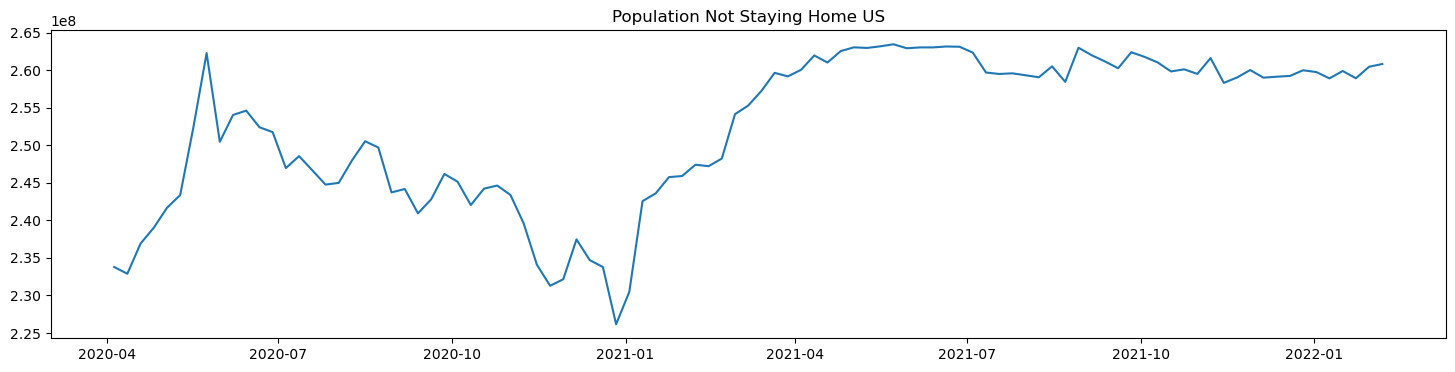

In [139]:
df_travel_us = travel_us.loc['2020-04':'2022-02']
plt.figure(figsize=(18,4))
#plt.plot(df_travel['Population Staying at Home'].rolling(window=1).mean());
plt.plot(df_travel_us['Population Not Staying at Home'].rolling(window=1).mean());
#plt.plot(df['moving_average_1'])
plt.title('Population Not Staying Home US')

In [140]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 4.7+ MB


In [141]:
df_cases

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2022-10-11,HI,348570,0,1682,0
2022-10-11,MP,13171,0,40,0
2022-10-11,UT,1040147,0,5028,0


In [142]:
df_cases = df_cases.groupby(by=df_cases.index).sum()
df_cases = df_cases.resample('W').mean()
df_cases

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2020-01-26,6.400000e+00,1.600000,0.000000e+00,0.000000
2020-02-02,9.142857e+00,0.714286,0.000000e+00,0.000000
2020-02-09,1.914286e+01,1.000000,0.000000e+00,0.000000
2020-02-16,2.242857e+01,0.571429,0.000000e+00,0.000000
2020-02-23,3.742857e+01,3.428571,0.000000e+00,0.000000
...,...,...,...,...
2022-09-18,9.539010e+07,58477.000000,1.048278e+06,408.000000
2022-09-25,9.576828e+07,52391.571429,1.051038e+06,392.285714
2022-10-02,9.610928e+07,45081.000000,1.053972e+06,355.142857


Text(0.5, 1.0, 'New cases')

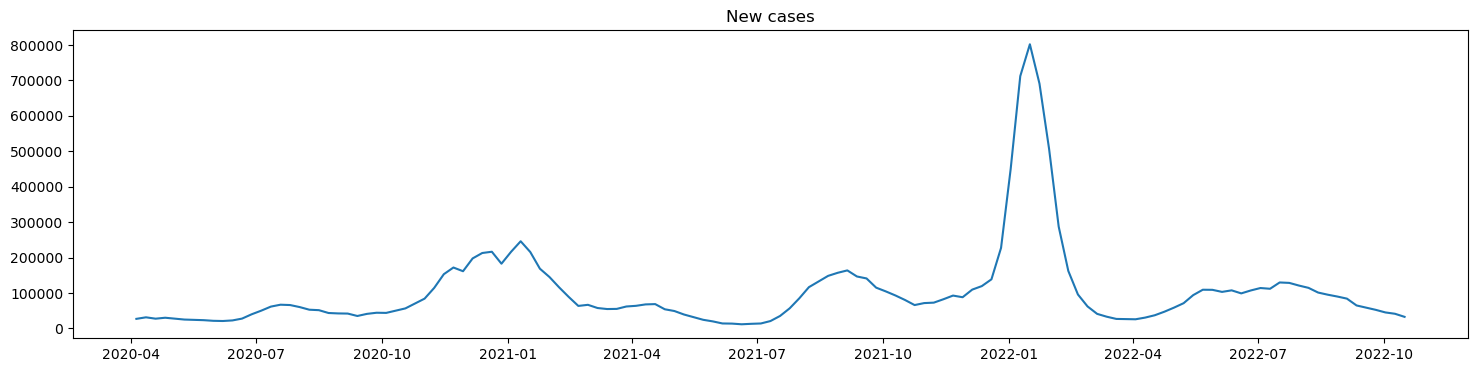

In [143]:
df_cases = df_cases.loc['2020-04':'2022-10']
plt.figure(figsize=(18,4))
#plt.plot(df_travel['Population Staying at Home'].rolling(window=1).mean());
plt.plot(df_cases['new_case'].rolling(window=1).mean());

#plt.plot(df['moving_average_1'])
plt.title('New cases')

Text(0.5, 1.0, 'Population Not Staying at Home US')

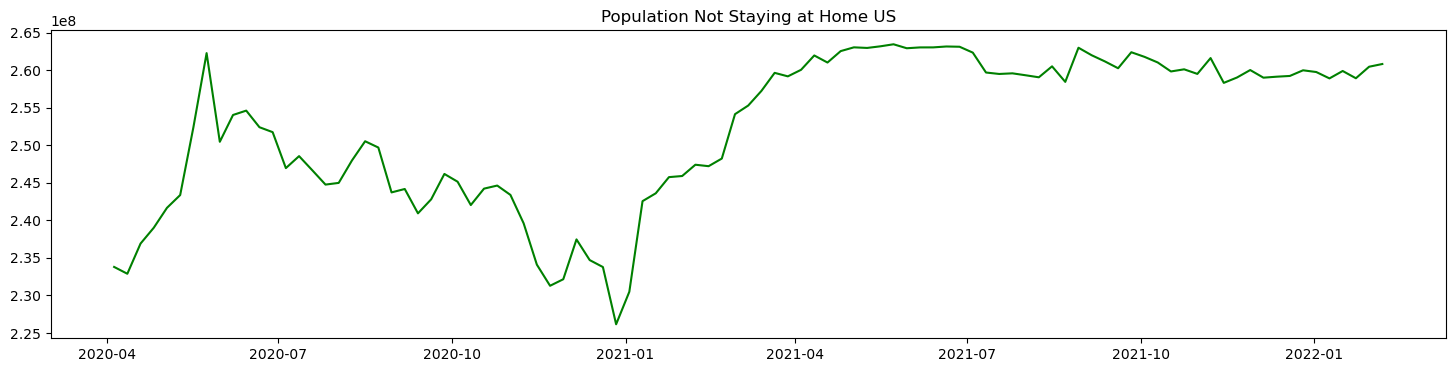

In [144]:
plt.figure(figsize=(18,4))
plt.plot(df_travel_us['Population Not Staying at Home'].rolling(window=1).mean(), color = 'Green');
plt.title('Population Not Staying at Home US')